# Clasificación Binaria

Los algoritmos de aprendizaje supervisado consisten en aprender un _mapa_ entre las variables características de los datos (_features_) y la variable objetivo (_target_). La meta es que el modelo ya entrenado pueda ser usado con nuevas observaciones de los features para predecir el target. Por este motivo, este tipo de algoritmos suele ser dividido gruesamente en dos categorias:
- Regresión: Cuando el(los) target(s) es continuo (como un numero real)
- Clasificación: Cuando el(los) target(s) es discreto (como una clase o categoría)

Las tareas de clasificación son luego subdivididas de acuerdo a cuantos targets uno intena predecir (_mono-target_ vs _multi-target_) y cuantos valores, o _clases_, puede tomar (binario vs multi-clase).

En la clase pasada vimos como acercarnos a problemas de Regresión usando modelos lineales. Hoy abordaremos los conceptos principales de tareas de Clasificación, considerando un problema simple de Clasificación Binaria de un solo target, al cual nos aproximaremos de una forma muy similar.

# Librerias

Como en todo proyecto, utilizaremos muchas funcionalidades disponibles en librerias abiertas. Para importarlas en el ambiente de trabajo, corre la siguiente celda:

In [61]:
#Funcionalidades para trabajar con datos estructurados en forma de Dataframes
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## Set de datos

Para mostrar de forma clara los conceptos, utilizaremos un dataset artificial. Este consiste en dos variables ($x$ e $y$) que identifican un punto en el plano. Estos puntos pueden pertenecer a dos clases diferentes ($target = 0$ o $1$).

La siguiente línea de codigo descargará el dataset a tu sistema local de archivos

In [62]:
import os.path
from pathlib import Path
file = Path('../guia3/binary_classification.csv')
if not file.is_file():
    ! wget https: // raw.githubusercontent.com/LCD-UNSAM/iaa2023c1/main/datasets/binary_classification.csv
!os.path.isfile('binary_classification.csv')


/bin/bash: -c: line 1: syntax error near unexpected token `'binary_classification.csv''
/bin/bash: -c: line 1: `os.path.isfile('binary_classification.csv')'


**Ejercicio**
- Importa los datos en el archivo `BinaryClassification1.csv` a un DataFrame de Pandas y visuliza las primersa filas.

*Pista: Prueba corriendo* `pd.read_csv?` y `pd.DataFrame.head?` y lee la documentación.

In [63]:
df = pd.read_csv('binary_classification.csv')
df.columns
df

,x,y,target
0,-0.422635,-0.932620,1.0
1,-3.036275,0.482545,0.0
2,-0.634106,-0.040808,1.0
3,-0.448945,0.330000,1.0
4,0.293817,0.638174,1.0
...,...,...,...
445,-1.797550,-2.414854,1.0
446,-0.853657,-0.420858,1.0
447,-0.242662,0.216986,1.0
448,-3.527124,0.114473,0.0


**Ejercicio**
- Grafica los datos usando la función `.plot`
- Explora visualizar las clases pintando los puntos de diferente color.

*Pistas:*
- *Usa `kind=scatter` para graficar puntos sueltos.*
- *El argumento `c` de la función `DataFrame.plot` se puede usar para especificar la columna que lleva informacion del color*

<Axes: xlabel='x', ylabel='y'>

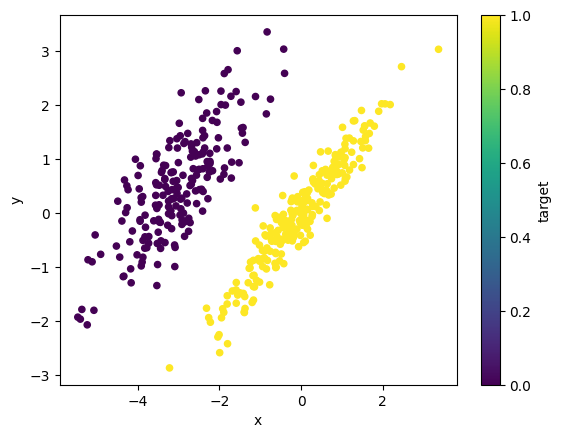

In [64]:
df.plot(kind='scatter' ,x='x', y='y',c='target')

## Primer Acercamiento a la clasificacion: Caso unidimensional.

Imaginemos que queremos clasificar este conjunto de datos en las dos clases provistas, utilizando solo la información de una variable, por ejemplo $x$. El acercamiento mas sencillo consistiría en:
- Establecer un valor de _umbral_ $x_u$
- Clasificar segun si $x>x_u$

Distintos valores de $x_u$ daran lugar a distintos resultados. Para medir que tan bueno o malo es el resultado, necesitamos de una metrica. Una metrica popular para clasificacion binaria de conjuntos de datos _balanceados_ (es decir, con similar cantidad de instancias en cada clase) es la _exactitud_ o _accuracy_. Esta no es otra cosa que la fracción de instancias bien clasificadas.

**Ejercicio**
- Grafique un histograma de la coordenada $x$ para cada clase. 
- Elija (a ojo) un valor de umbral $x_u$ 
- Cree un vector con sus predicciones $pred$, y mida cual es la exactitud de su predicción.
- Pruebe con distintos valores de umbral, tambien puede probar el mismo procedimiento en la variable $y$. ¿Cual es el mejor _modelo_ que obtiene?

In [65]:
x_u = -3
pred = df['x'] > x_u
pred


0       True
1      False
2       True
3       True
4       True
       ...  
445     True
446     True
447     True
448    False
449     True
Name: x, Length: 450, dtype: bool

In [82]:
df['pred'] =  pred.astype('float')
df.iloc[0:2]

,x,y,target,pred
0,-0.422635,-0.932620,1.0,1.0
1,-3.036275,0.482545,0.0,0.0


In [91]:
exactitud = df.groupby(['target','pred']).size()
exactitud[0]

pred
0.0    105
1.0     95
dtype: int64

Debajo hay un snippet para visualizar esta clasificación en el gráfico bidimensional. Asegúrate que el vector de predicciones se llama `pred`, el umbral elegido `x_u`, y el DataFrame `df` contenga las columnas originales `x`, `y` y `target`.

<function matplotlib.pyplot.legend(*args, **kwargs)>

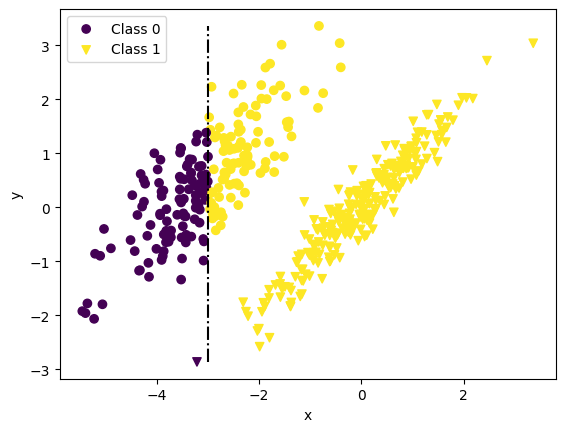

In [66]:
plt.scatter(df[df.target==0].x, df[df.target==0].y, marker='o', c=pred[df.target==0], label='Class 0')
plt.scatter(df[df.target==1].x, df[df.target==1].y, marker='v', c=pred[df.target==1], label='Class 1')
plt.legend()
plt.vlines(x_u,df.y.min(), df.y.max(), ls='-.', colors='black')
plt.xlabel("x")
plt.ylabel("y")
plt.legend

## Segundo acercamiento: Caso bi(multi)-dimensional

Los modelos lineales de clasificación consisten en esto: Trazar una línea recta que divida de un lado una clase y de otro lado otra. En el caso de mas de 2 dimensiones, es colocar un hiperplano que divida el espacio en dos mitades: A un lado y el otro del hiperplano, clasificamos como una u otra clase. 

La manera matemática de caracterizar una linea recta en un plano es con una simple ecuación:
$$
w_1  x + w_2 y = cte
$$
donde $w_1$ y $w_2$ determinan el angulo de la linea, y la constante mueve paralelamente esa recta. Esta constante no es otra cosa que el _umbral_ que elegimos en la sección anterior ($x_u$), mientras que los numeros $w_i$ se le llaman _pesos_ y en el caso de una dimensión de la sección anterior corresponde a tomar $w_2=0$ y $w_1=1$ (una linea vertical).

En el caso mas general de $N$ dimensiones, generaliza de igual forma:
$$
w_0 + w_1  x_1 + w_2 x_2 + ... + w_N  x_N = 0
$$
(donde llamamos al umbral $-w_0$ para llevar la ecuación a una forma convencional).

- Al hiperplano que separa los puntos se le llama **_"frontera de decisión"_**. 

- Este esta caracterizado por ser donde se anula la función lineal $f(\vec w, \vec x) = w_0 + w_1  x_1 + w_2 x_2 + ... + w_N  x_N $

- A la función usada para clasificar se le llama **función discriminante**.


**Ejericio**
Utilice las funciones definidas debajo para encontrar la mejor frontera de decisión.

In [67]:
def model(w, x, y):
    return w[0] +w[1]*x + w[2]*y > 0

def plot(x, y, target, pred, w=[]):

    plt.scatter(x[target==0], y[target==0], marker='o', c=np.where(pred[target==0], 'r', 'b'), label='Class 0')
    plt.scatter(x[target==1], y[target==1], marker='v', c=np.where(pred[target==1], 'r', 'b'), label='Class 1')
    plt.legend()
    if len(w) >= 3 and (w[2]!=0 or w[1]!=0):
        if w[2]==0:
            plt.vlines(-w[0]/w[1],df.y.min(), df.y.max(), ls='-.', colors='black')
        else:
            u = np.linspace(min(x), max(x), 100)
            v = -(w[0] + w[1]*u) / w[2]
            plt.plot(u,v, ls='-.', c='black')        
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()


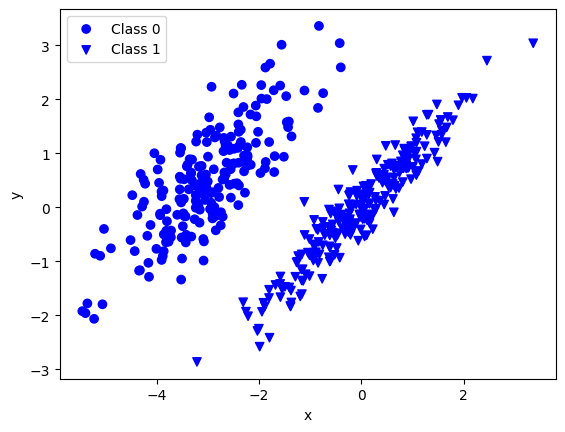

In [68]:
#Tu turno...
w =[
    0, #w0
    0, #w1
    0, #w2
    ]

preds = model(w, df.x, df.y)
plot(df.x, df.y, df.target, preds, w=w)

Este es el mas sencillo de los métodos llamados de _función discriminante_. Estos consisten en ajustar una función escalar, cuyo valor determina la clase a la que pertenece, dependiendo de si está por encima o debajo del _umbral de decisión_.

A esta función lineal, cuando se aparea con un método particular para elegir los pesos $w$, se le llama _modelo_. Un caso particular es el llamado _Perceptrón_ que corresponde a elegir el $w$ que minimice el número de puntos mal clasificados.

## [Opcional] Un poco de teoría: Función de Pérdida

Como vemos, los modelos de machine learning no son mas que parametrizaciones de como tomar una decisión. En el caso de modelos lineales, tomamos una combinacion lineal de todos nuestros features, cuyos coeficientes (los pesos $w$) son los parámetros del modelo. 

El procedimiento de **_entrenar_** un modelo consiste en encontrar cual es la _mejor_ combinación de parámetros de un modelo sobre un dataset. Lo unico que nos falta es definir que significa "mejor", para esto es que se usa una _función de pérdida_. Esta es una función que toma las predicciones $p$ de nuestro modelo (que a su vez depende de los parámetros $\vec w$ y los features del dataset $X$) y el objetivo o target $t$, y devuelve un número que nos dice que tan _lejos_ esta el modelo de predecir bien: 
$$ \mathcal{L} = \mathcal{L}(p, t) = f(\vec w, X, \vec t).$$ 

El problema de entrenamiento pasa a ser un problema de _optimización_: Dado $X$ y $\vec t$, encontrar los $\vec w$ que minimizan la función de pérdida $\mathcal{L}$. $$\vec w_{best} = \left. \argmin_{\vec w} \mathcal{L} (\vec p, \vec t) \right|_{X, \vec t}$$
Afortunadamente, este problema de optimización es uno de los mas estudiados en ciencias de la computación y hoy en dia contamos con algoritmos muy eficientes para su resolución.

Entre las posibles funciones de pérdida, podemos mencionar dos que dan lugar a dos modelos diferentes
- *Pérdida 0-1*: 

Por cada punto mal clasificado, sumamos 1 a la funcion de perdida, y por cada punto bien clasificado 0. Esto da lugar al algoritmo conocido como _**Perceptrón**_ de importancia histórica. Esta función de pérdida la podemos escribir como $$\mathcal{L}(p,y) = \sum_i max(0; - (2 p_i-1) (2 t_i - 1) )$$
donde la predicción del modelo es
$$
p_i=   \left\{
    \begin{array}{ll}
    1 & {\rm if }\; w_0 + w_1 x^{(i)}_1 + ... + + w_N x^{(i)}_N \ge 0 \\
    0 & {\rm if }\; w_0 + w_1 x^{(i)}_1 + ... + + w_N x^{(i)}_N < 0 \\
    \end{array} 
    \right. $$

- Entropía cruzada binaria:

Esta función de error tiene su origen en la teoría de la información, y es la que caracteriza al modelo del _**Regresor Logístico**_. Se puede escribir como

$$\mathcal{L}(\vec p, \vec t) = \sum_i \left[ - t_i \log(p_i) - (1-t_i) \log(1-p_i)\right]$$

Con la diferencia en que aquí la predicción del modelo $p_i$ no es 0 o 1, sino un número entre 0 y 1, que representa _la probabilidad de que la instancia $x^{(i)}$ pertenezca a la clase 1_.

## Regresor Logístico

El regresor logístico es un método discrtiminativo, es decir que nos provee no solo la predicción de _a que clase pertenece una muestra_, sino que responde a la pregunta de _cual es la probabilidad de que una muestra pertenezca a una clase_. Esta probabilidad podrá ser luego usada para clasificar (es decir, usando la probabilidad como función discriminante), donde se asigna cada muestra a la clase más probable (umbral = 0.5) o de otra forma a su elección.

Es un _modelo lineal generalizado_, es decir que se basa en un modelo lineal cuyo resultado se pasa por una _función de vínculo_ que en este caso es la función sigmoide. 
Matemáticamente:
$$ p = \sigma(w_0 + w_1 x^{(i)}_1 + ... + + w_N x^{(i)}_N) $$ 

siendo $\sigma $ la función sigmoide $\sigma(z) = \frac{1}{1 + e^{-z}}$

Text(0, 0.5, '$\\sigma (z)$')

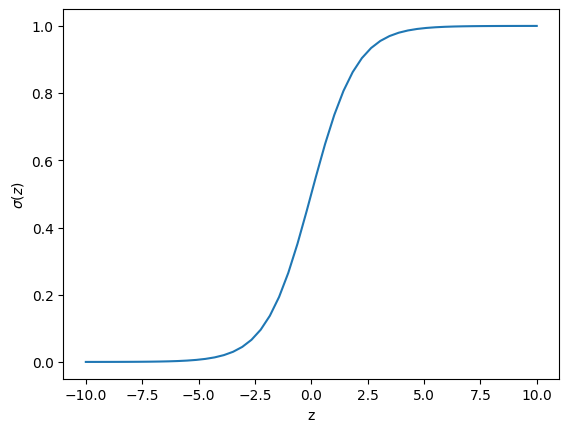

In [69]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-10,10)
plt.plot(z, sigmoid(z))
plt.xlabel("z")
plt.ylabel("$\sigma (z)$")

A esta parametrización se la aparea con la funcíon de pérdida de _entropía cruzada binaria_ para dar como resultado el regresor logístico. La base matemática de esta elección tiene fundamentos en teoría de la probabilidad, que escapan al marco de esta materia.

**Ejercicio**

1. Use el regresor logístico (importado de Scikit-Learn al comienzo del notebook) para ajustar los datos (setee el parámetro `penalty = 'none'`)

*Pistas: El input del modelo X es una matriz cuyas filas son muestras, y cuyas columnas son features. Utilice la funcion `.to_numpy()` de pandas para pasar del DataFrame a arrays de numpy*


In [70]:
#Tu turno...


2. Calcule el vector de probabilidades predichas por el modelo ajustado sobre el dataset. Examine e interprete su resultado.

*Pistas: `.predict_proba(X)`*


In [71]:
#Tu turno ...


3. Obtenga los pesos del modelo lineal, utilicelos para graficaar la frontera de decisión

*Pistas:*
- *Considere los atributos `.coef` y `.intercept_` del regresor logístico.*
- *La función sigmoide toca el umbral 0.5 cuando el modelo lineal vale 0, $\sigma(0)=0.5$. Sabiendo esto, valerse de la función de ploteo utilizada anterioremente*

In [72]:
# Tu turno...


### Formulario de asistencia

Por favor, no olviden completar el siguiente formulario antes del miércoles 05/04 a la 23:59.

https://forms.gle/EQ3UMLK1BzaZschU7

# Extra: Dataset de EcoBicis

Utilizando el dataset de la clase anterior (Ecobicis):

1. Elija una variable objetivo binaria que considere interesante
2. Prepare el dataset para un problema de clasificación. Elija los features, preproceselos y separelos en una matrix `X` de la variable objetivo en un nuevo `t`.
3. Entrene un Regresor Logístico sobre el set de datos. 
4. Evalúe exactitud (porcentaje de predicciones correctas) de su modelo sobre el set de entrenamiento.


In [73]:
# Tu turno...
